<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_4_%E6%B7%B1%E5%B1%A4%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPUの確認
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cd348206-926f-817d-ccaf-38184602965a)


# 深層ガウス過程

In [ ]:
#@title install packages
!pip install gpytorch
!pip install optuna
!pip install watermark

     |████████████████████████████████| 310 kB 4.9 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=845135cc85fefeefd43a0ba1a53c664175b2788e44dd0cd73cde5116620b0226
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
     |████████████████████████████████| 308 kB 4.9 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 210 kB 44.5 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 146 kB 46.9 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 62.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cac9d154e294f192078d9eeeb14c5b34f91069203a53eac5451a80c0d9d80bc2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8

## 実装


In [ ]:
#@title import packages
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader

import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

sns.reset_defaults()
sns.set_context(context='talk', font_scale=1.0)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
def set_seed(seed):
    # random
    # random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

### 利用データ


In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB


,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


In [ ]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 説明変数、観測変数の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 参考文献では元のスケールにおけるRMSEを算出しているため、統計量を求めておく。
m, s = y_train.mean(), y_train.std(ddof=0)
y_train = (y_train.values - m) / s
y_test = (y_test.values - m) / s

dtype = torch.float32
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, dtype=dtype), 
    torch.tensor(X_test, dtype=dtype), 
    torch.tensor(y_train, dtype=dtype), 
    torch.tensor(y_test, dtype=dtype)
    )

# データをGPUに配置
if torch.cuda.is_available():
    (X_train, X_test, y_train, y_test) = (
        X_train.cuda(), X_test.cuda(), y_train.cuda(), y_test.cuda()
    )

# ミニバッチを読み込むためのDataLoaderを作成
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

### モデルの実装

In [ ]:
class DeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            # 誘導点の初期値の設定（標準正規分布からサンプリング。引数はshapeを表す）
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        # 近似事後分布の設定
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            # 誘導点の位置を学習対象のパラメータとする
            learn_inducing_locations=True
        )

        super(DeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        # 平均関数の設定
        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            # RBFカーネルを設定
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
class DGP(DeepGP):
    def __init__(self, input_dim, hidden_dim):
        hidden_layer = DeepGPHiddenLayer(
            input_dims=input_dim,
            output_dims=hidden_dim,
            # 隠れ層は線形平均関数を利用
            mean_type='linear',
        )

        last_layer = DeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            # 観測変数は１次元のため、Noneに設定
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        # 推論の際は勾配計算は不要
        with torch.no_grad():
            mus = []
            variances = []
            for x_batch, y_batch in test_loader:
                # 予測分布を表すMultivariateNormalクラスのオブジェクト
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1)

In [ ]:
input_dim = hidden_dim = X_train.shape[-1]
model = DGP(input_dim, hidden_dim)
if torch.cuda.is_available():
    model = model.cuda()

### 推論

In [ ]:
num_epochs = 200
num_samples = 10

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)

# 目的関数の設定
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, X_train.shape[-2]))

losses = []
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    epoch_loss = []
    for x_batch, y_batch in train_loader:
        # 尤度の計算に用いるサンプル数の設定
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Text(0, 0.5, 'loss')

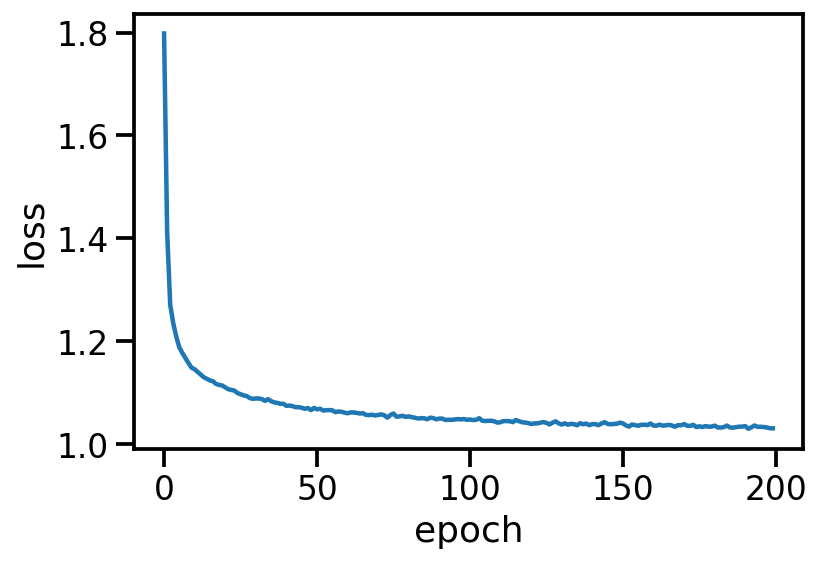

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

### 予測・性能評価

In [ ]:
model.eval()
# 予測分布の平均、分散
predictive_means, predictive_variances = model.predict(test_loader)

mse = mean_squared_error(y_test.cpu(), predictive_means.mean(0).cpu()) * s**2
print(f'RMSE(DGP): {mse**0.5:.2f}')

RMSE(DGP): 3.86


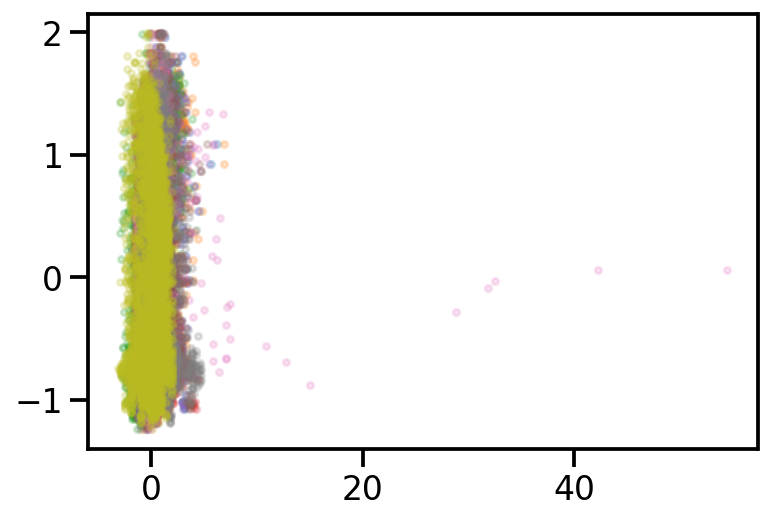

In [ ]:
y_pred = predictive_means.mean(0).cpu().numpy()

for i in range(9):
    plt.scatter(X_test[:, i].cpu(), y_pred, s=10, alpha=0.2)

# Sparse GP

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X_train[:500, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
import numpy as np

num_epochs = 30

model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

losses = []
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    epoch_loss = []
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

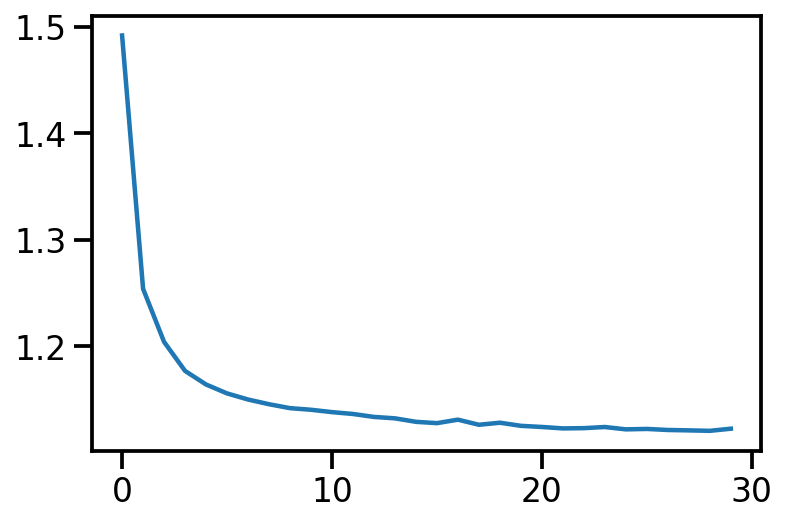

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
means = means[1:]

In [ ]:
mse = mean_squared_error(y_test.cpu(), means.cpu()) * s**2

print(f'RMSE(GP): {mse**0.5:.2f}')

RMSE(GP): 4.41


In [ ]:
# for i in range(9):
#     plt.figure()
#     plt.scatter(X_test[:, i].cpu(), means, s=10, alpha=0.2)

# LinearRegerssion

In [ ]:
import statsmodels.api as sm

X_train, X_test, y_train, y_test = (
    X_train.cpu().numpy(), X_test.cpu().numpy(), y_train.cpu().numpy(), y_test.cpu().numpy()
)

X_train_sm = sm.add_constant(X_train)

mod = sm.OLS(y_train, X_train_sm)
res = mod.fit()
print(res.summary())

y_pred = res.predict(sm.add_constant(X_test))
mse = mean_squared_error(y_test, y_pred) * m**2
print(f'RMSE(linear regression): {mse**0.5:.2f}')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        02:49:21   Log-Likelihood:                -51545.
No. Observations:               41157   AIC:                         1.031e+05
Df Residuals:                   41147   BIC:                         1.032e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.759e-10      0.004  -6.61e-08      1.0

In [ ]:
%load_ext watermark
%watermark --iversions

matplotlib : 3.2.2
tqdm       : 4.64.0
seaborn    : 0.11.2
pandas     : 1.3.5
numpy      : 1.21.6
IPython    : 5.5.0
statsmodels: 0.10.2
gpytorch   : 1.6.0
torch      : 1.11.0+cu113

